In [1]:
import matplotlib.cm as cm
from time import time
from matplotlib import lines as mlines
import numpy as np
from jax import random as jran

ran_key = jran.PRNGKey(180)

## Load simulation data with diffprof fits

In [2]:
import os
from astropy.table import Table
diffprof_drn = "/Users/aphearin/work/DATA/diffprof_data"
mdpl2 = Table.read(os.path.join(diffprof_drn, "MDPL2_halo_table.hdf5"))
bpl = Table.read(os.path.join(diffprof_drn, "BPL_halo_table.hdf5"))
print(bpl.keys())

['halo_id', 'conc_beta_early', 'conc_beta_late', 'conc_k', 'conc_lgtc', 'u_conc_beta_early', 'u_conc_beta_late', 'u_conc_k', 'u_conc_lgtc', 'logmp', 'mah_early', 'mah_late', 'mah_logtc', 'mah_k', 'log_mah_fit', 'conch_fit', 'tform_50', 'p_tform_50']


## Calculate dpp approximations for $c(t)$ for every halo

In [3]:
from diffprof.nfw_evolution import lgc_vs_lgt

lgc_vs_lgt_vmap = jjit(jvmap(lgc_vs_lgt, in_axes=(None, 0, 0, 0, 0)))

N_T = 25
TARR_FIT = np.linspace(3.5, 13.8, N_T)

lgconc_history_bpl = np.array(lgc_vs_lgt_vmap(
    np.log10(TARR_FIT), bpl["conc_lgtc"], bpl["conc_k"], bpl["conc_beta_early"], bpl["conc_beta_late"]))
lgconc_history_mdpl2 = np.array(lgc_vs_lgt_vmap(
    np.log10(TARR_FIT), mdpl2["conc_lgtc"], mdpl2["conc_k"], mdpl2["conc_beta_early"], mdpl2["conc_beta_late"]))


## Measure sumstats of $c(t)$ for simulated halo samples

### Use pseudo-random subsamples of halos for target data

In [4]:
# from diffprof.latin_hypercube import get_scipy_kdtree, retrieve_lh_sample_indices
# tree_bpl = get_scipy_kdtree(bpl['logmp'])
# tree_mdpl2 = get_scipy_kdtree(mdpl2['logmp'])

# indx_bpl = retrieve_lh_sample_indices(tree_bpl, 11.85, 13.4, 1, 100_000)
# indx_mdpl2 = retrieve_lh_sample_indices(tree_mdpl2, 13.4, 14.2, 1, 100_000)

# from diffprof.get_target_simdata import target_data_generator

# N_MH_TARGETS, N_P_TARGETS = 10, 10

# args = (bpl['logmp'][indx_bpl],
#     mdpl2['logmp'][indx_mdpl2],
#     lgconc_history_bpl[indx_bpl],
#     lgconc_history_mdpl2[indx_mdpl2],
#     bpl['p_tform_50'][indx_bpl],
#     mdpl2['p_tform_50'][indx_mdpl2],
#     N_MH_TARGETS,
#     N_P_TARGETS,
#        )
# gen = target_data_generator(*args, lgmh_min=12.0, lgmh_max=14.1, p50_min=0.1, p50_max=0.9)

# target_data = next(gen)
# lgmhalo_targets, p50_targets = target_data[0:2]
# target_avg_log_conc_lgm0, target_std_log_conc_lgm0 = target_data[2:4]
# target_avg_log_conc_p50_lgm0, _target_std_log_conc_p50_lgm0 = target_data[4:]

### Alternatively use manually-declared halo samples

In [5]:
from diffprof.latin_hypercube import get_scipy_kdtree, retrieve_lh_sample_indices
tree_bpl = get_scipy_kdtree(bpl['logmp'])
tree_mdpl2 = get_scipy_kdtree(mdpl2['logmp'])

indx_bpl = retrieve_lh_sample_indices(tree_bpl, 11.85, 13.4, 1, 100_000)
indx_mdpl2 = retrieve_lh_sample_indices(tree_mdpl2, 13.4, 14.2, 1, 100_000)

from diffprof.get_target_simdata import calculate_halo_sample_target_data

lgmhalo_targets = np.array((12.0, 13.0, 14.0))
p50_targets = np.linspace(0.1, 0.9, 20)

args = (bpl['logmp'][indx_bpl], mdpl2['logmp'][indx_mdpl2], 
        lgconc_history_bpl[indx_bpl], lgconc_history_mdpl2[indx_mdpl2], 
       bpl['p_tform_50'][indx_bpl], mdpl2['p_tform_50'][indx_mdpl2], 
        lgmhalo_targets, p50_targets)
args = (bpl['logmp'], mdpl2['logmp'], 
        lgconc_history_bpl, lgconc_history_mdpl2, 
       bpl['p_tform_50'], mdpl2['p_tform_50'], 
        lgmhalo_targets, p50_targets)

res = calculate_halo_sample_target_data(*args)
target_sim_avg_log_conc_lgm0, target_sim_std_log_conc_lgm0 = res[:2]
target_sim_avg_log_conc_p50_lgm0, _target_sim_std_log_conc_p50_lgm0 = res[2:]

## Use target data model

In [6]:
lgmhalo_targets = np.array((12.0, 13.0, 14.0))
p50_targets = np.linspace(0.1, 0.9, 20)

N_MH_TARGETS, N_P_TARGETS = lgmhalo_targets.size, p50_targets.size

In [7]:
from diffprof import target_data_model as tdm

### Generate target data for $\sigma(c(t)\vert M_{\rm malo})$

In [8]:
std_lgc_lgm12 = tdm.approx_std_lgconc_vs_lgm(TARR_FIT, 12, *tdm.target_data_model_params_std_lgconc.values())
std_lgc_lgm13 = tdm.approx_std_lgconc_vs_lgm(TARR_FIT, 13, *tdm.target_data_model_params_std_lgconc.values())
std_lgc_lgm14 = tdm.approx_std_lgconc_vs_lgm(TARR_FIT, 14, *tdm.target_data_model_params_std_lgconc.values())

target_std_log_conc_lgm0 = np.concatenate(
    [tdm.approx_std_lgconc_vs_lgm(TARR_FIT, lgm, *tdm.target_data_model_params_std_lgconc.values()) 
    for lgm in lgmhalo_targets]).reshape((N_MH_TARGETS, N_T))

### Generate target data for $\langle c(t)\vert M_{\rm malo}\rangle$

In [9]:
pars = list(tdm.target_data_model_params_mean_lgconc.values())

target_avg_log_conc_lgm0 = np.zeros((N_MH_TARGETS, N_T))
for im, lgm in enumerate(lgmhalo_targets):
    mean_lgc_lgm = np.mean(np.array(
        [tdm.approximate_lgconc_vs_lgm_p50(TARR_FIT, lgm, p, *pars) for p in p50_targets]), axis=0)
    target_avg_log_conc_lgm0[im, :] = mean_lgc_lgm

### Generate target data for $\langle c(t)\vert M_{\rm malo}, p_{50\%}\rangle$

In [10]:
target_avg_log_conc_p50_lgm0 = np.zeros((N_MH_TARGETS, N_P_TARGETS, N_T))

for im, lgm in enumerate(lgmhalo_targets):
    mean_lgc_lgm_p50 = np.array(
        [tdm.approximate_lgconc_vs_lgm_p50(TARR_FIT, lgm, p, *pars) for p in p50_targets])
    target_avg_log_conc_p50_lgm0[im, :, :] = mean_lgc_lgm_p50

## Generate predictions of best-fitting model

In [11]:
from dev_new_loss import _get_grid_data
from diffprof.dpp_opt import get_u_param_grids

n_grid = 2500
grid_key, ran_key = jran.split(ran_key, 2)
u_be_grid, u_lgtc_bl_grid = get_u_param_grids(grid_key, n_grid)

grid_data = _get_grid_data(p50_targets, TARR_FIT, u_be_grid, u_lgtc_bl_grid)

In [12]:
from diffprof.bpl_dpp import DEFAULT_PARAMS
dpp_params = np.array(list(DEFAULT_PARAMS.values()))
# dpp_params = np.load("new_p_best.npy")

In [13]:
from dev_new_loss import _mse_loss_multimass

_mse_loss_multimass(
    dpp_params, grid_data, lgmhalo_targets, 
    target_sim_avg_log_conc_p50_lgm0, target_sim_avg_log_conc_lgm0, target_sim_std_log_conc_lgm0)

DeviceArray(0.0044608, dtype=float32)

In [14]:
from diffprof.fitting_helpers.utils import jax_adam_wrapper
from dev_new_loss import _global_loss_func

global_loss_data = (grid_data, lgmhalo_targets, target_sim_avg_log_conc_p50_lgm0,
                    target_sim_avg_log_conc_lgm0, target_sim_std_log_conc_lgm0)


loss = _global_loss_func(dpp_params, global_loss_data)
print("initial log10(loss) = {:.3f}".format(np.log10(loss)))

from jax import value_and_grad
_global_loss_func_and_grad = value_and_grad(_global_loss_func, argnums=0)
loss_and_grads = _global_loss_func_and_grad(dpp_params, global_loss_data)

initial log10(loss) = -2.351


## Reoptimize parameters

In [20]:
n_steps = 250
_res = jax_adam_wrapper(_global_loss_func, dpp_params, global_loss_data, n_steps, n_warmup=2)
p_best, loss, loss_history = _res[:3]
print("final log10(loss) = {:.3f}".format(np.log10(loss)))


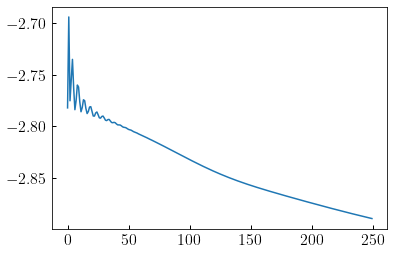

In [21]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(np.log10(loss_history))

In [23]:
np.save('new_p_best', p_best)

In [24]:
from diffprof.dpp_predictions import _get_preds_singlemass
from jax import vmap

_m = (None, 0, *[None]*4)
_get_preds_multimass = jjit(vmap(_get_preds_singlemass, in_axes=_m))

_preds = _get_preds_multimass(p_best, lgmhalo_targets, TARR_FIT, p50_targets, u_be_grid, u_lgtc_bl_grid)
pred_avg_log_conc_p50, pred_avg_log_conc_lgm0, pred_std_log_conc_lgm0, pred_std_log_conc_p50 = _preds


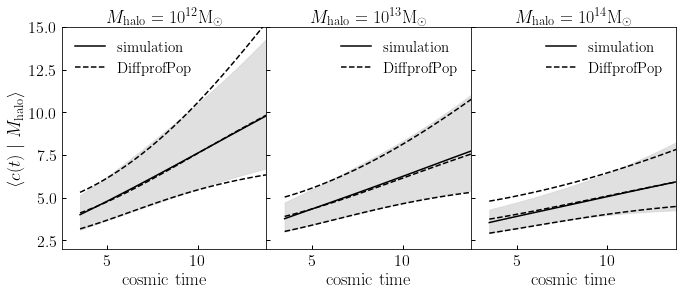

In [25]:
from scipy.stats.mstats import trimmed_mean, trimmed_std


fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11, 4))
(ax0, ax1, ax2) = axes
fig.subplots_adjust(wspace=0, hspace=0)
xlim = ax0.set_xlim(2.5, 13.75)
ylim = ax0.set_ylim(2, 15)

MHALO_LABELS = (r'$M_{\rm halo}=10^{12}{\rm M_{\odot}}$', 
          r'$M_{\rm halo}=10^{13}{\rm M_{\odot}}$',
          r'$M_{\rm halo}=10^{14}{\rm M_{\odot}}$')
for im, ax in enumerate(axes):

#     __=ax.plot(TARR_FIT, 10**target_avg_log_conc_lgm0[im, :], color='k', label=r'${\rm simulation}$')
    __=ax.plot(TARR_FIT, 10**target_sim_avg_log_conc_lgm0[im, :], color='k', label=r'${\rm simulation}$')
    __=ax.plot(TARR_FIT, 10**pred_avg_log_conc_lgm0[im, :], '--', color='k', label=r'${\rm DiffprofPop}$')

#     lgylo = target_avg_log_conc_lgm0[im, :] - target_std_log_conc_lgm0[im, :]
#     lgyhi = target_avg_log_conc_lgm0[im, :] + target_std_log_conc_lgm0[im, :]
#     __=ax.fill_between(TARR_FIT, 10**lgylo, 10**lgyhi, color='lightgray', alpha=0.7)

    lgylo = target_sim_avg_log_conc_lgm0[im, :] - target_sim_std_log_conc_lgm0[im, :]
    lgyhi = target_sim_avg_log_conc_lgm0[im, :] + target_sim_std_log_conc_lgm0[im, :]
    __=ax.fill_between(TARR_FIT, 10**lgylo, 10**lgyhi, color='lightgray', alpha=0.7)

    lgylo = pred_avg_log_conc_lgm0[im, :] - pred_std_log_conc_lgm0[im, :]
    lgyhi = pred_avg_log_conc_lgm0[im, :] + pred_std_log_conc_lgm0[im, :]
    __=ax.plot(TARR_FIT, 10**lgylo, '--', color='k')
    __=ax.plot(TARR_FIT, 10**lgyhi, '--', color='k')

    xlabel = ax.set_xlabel(r'${\rm cosmic\ time}$')
    title = ax.set_title(MHALO_LABELS[im])
    leg = ax.legend()
ylabel = ax0.set_ylabel(r'$\langle c(t)\ \vert\ M_{\rm halo}\rangle$')

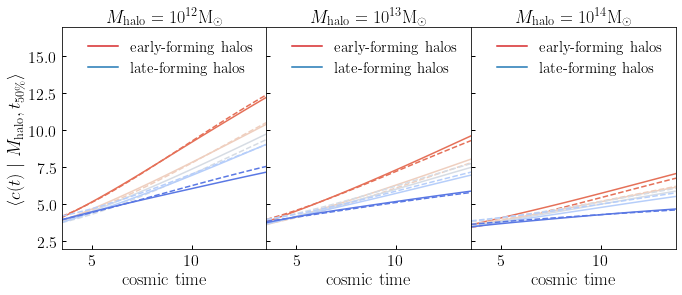

In [26]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11, 4))
(ax0, ax1, ax2) = axes
fig.subplots_adjust(wspace=0, hspace=0)
xlim = ax0.set_xlim(3.5, 13.75)
ylim = ax0.set_ylim(2, 17)

from matplotlib import lines as mlines
red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'${\rm early}$-${\rm forming\ halos}$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'${\rm late}$-${\rm forming\ halos}$')

import matplotlib.cm as cm
from matplotlib import lines as mlines
colormap_seq=np.linspace(1, 0, p50_targets.size)
colors=cm.coolwarm(colormap_seq)

indx_p50_plot = np.searchsorted(p50_targets, np.array([0.2, 0.4, 0.5, 0.6, 0.8]))
p50_plot = p50_targets[indx_p50_plot]

for im, ax in enumerate(axes):
    for ip in indx_p50_plot:
        __=ax.plot(TARR_FIT, 10**target_sim_avg_log_conc_p50_lgm0[im, ip, :], color=colors[ip])
        __=ax.plot(TARR_FIT, 10**pred_avg_log_conc_p50[im, ip, :], '--', color=colors[ip])

    xlabel = ax.set_xlabel(r'${\rm cosmic\ time}$')
    title = ax.set_title(MHALO_LABELS[im])

    leg=ax.legend(handles=[red_line, blue_line])

ylabel = ax0.set_ylabel(r'$\langle c(t)\ \vert\ M_{\rm halo}, t_{50\%}\rangle$')